In [4]:
##Editor Qiuming Li
import torch
import torch.nn as nn
import torch.utils as utils
from torch.autograd import Variable
import torchvision.datasets as dset
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt

In [5]:
torch.manual_seed(1)
##define Hyperparameter 
n_epoch=25
batch_size=8
learning_rate=0.0001

In [6]:
mnist_train=dset.MNIST("./",train=True,transform=transforms.ToTensor(),target_transform=None,download=True)
train_loader=torch.utils.data.DataLoader(dataset=mnist_train,batch_size=batch_size,shuffle=True)

In [7]:
## define encoder like downsampling in unet
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder,self).__init__()
        self.layer1=nn.Sequential(
            nn.Conv2d(1,32,3,padding=1),#batch*32*28*28
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Conv2d(32,32,3,padding=1),#batch*32*28*28
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Conv2d(32,64,3,padding=1),#batch*64*28*28
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Conv2d(64,64,3,padding=1),#batch*64*28*28
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(2,2)#batch*64*14*14
        )
        self.layer2=nn.Sequential(
            nn.Conv2d(64,128,3,padding=1),#batch*128*14*14
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.Conv2d(128,128,3,padding=1),#batch*128*14*14
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(2,2),
            nn.Conv2d(128,256,3,padding=1),#batch*256*14*14
            nn.ReLU()
        )
    def forward(self,x):
        out=self.layer1(x)
        out=self.layer2(out)
        out=out.view(batch_size,-1)
        return out

encoder=Encoder().cuda()

In [8]:
##define Decoder like upsampling in unet
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder,self).__init__()
        self.layer1=nn.Sequential(
            nn.ConvTranspose2d(256,128,3,2,1,1),#batch*128*14*14
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.ConvTranspose2d(128,128,3,1,1),#batch*128*14*14
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.ConvTranspose2d(128,64,3,1,1),#batch*64*14*14
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.ConvTranspose2d(64,64,3,1,1),#batch*64*14*14
            nn.ReLU(),
            nn.BatchNorm2d(64)
        )
        self.layer2=nn.Sequential(
            nn.ConvTranspose2d(64,32,3,1,1),#batch*32*14*14
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.ConvTranspose2d(32,32,3,1,1),#batch*32*14*14
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.ConvTranspose2d(32,1,3,2,1,1),#batch*1*28*28
            nn.ReLU()
        )
    def forward(self,x):
        out=x.view(batch_size,256,7,7)
        out=self.layer1(out)
        out=self.layer2(out)
        return out
decoder=Decoder().cuda()

##Loss function and define Adam optimizer
parameters=list(encoder.parameters())+list(decoder.parameters())
loss_func=nn.MSELoss()
optimizer=torch.optim.Adam(parameters,lr=learning_rate)

###to train the model
#add noise 
noise=torch.rand(batch_size,1,28,28)
for I in range(n_epoch):
    for image,label in train_loader:
        image_n=torch.mul(image+0.25,0.1*noise)
        image=Variable(image).cuda()
        image_n=Variable(image_n).cuda()
        optimizer.zero_grad()
        output=encoder(image_n)
        output=decoder(output)
        loss=loss_func(output,image)
        loss.backward()
        optimizer.step()
        break
    print('epoch[{}/{}],loss:{:.4f}'.format(I+1,n_epoch,loss.item()))

epoch[1/25],loss:1.0769
epoch[2/25],loss:0.8615
epoch[3/25],loss:0.6337
epoch[4/25],loss:0.3590
epoch[5/25],loss:0.2197
epoch[6/25],loss:0.1538
epoch[7/25],loss:0.1310
epoch[8/25],loss:0.1105
epoch[9/25],loss:0.1157
epoch[10/25],loss:0.1007
epoch[11/25],loss:0.1047
epoch[12/25],loss:0.0919
epoch[13/25],loss:0.0944
epoch[14/25],loss:0.0878
epoch[15/25],loss:0.0906
epoch[16/25],loss:0.0863
epoch[17/25],loss:0.0849
epoch[18/25],loss:0.0896
epoch[19/25],loss:0.0818
epoch[20/25],loss:0.0590
epoch[21/25],loss:0.0756
epoch[22/25],loss:0.0655
epoch[23/25],loss:0.0757
epoch[24/25],loss:0.0676
epoch[25/25],loss:0.0590


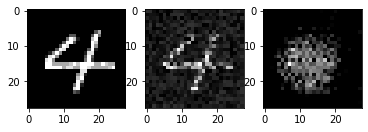

tensor(4)


In [9]:
img=image[0].cpu()
input_img=image_n[0].cpu()
output_img=output[0].cpu()
origin=img.data.numpy()
inp=input_img.data.numpy()
out=output_img.data.numpy()
plt.figure('denoising autoencoder')
plt.subplot(131)
plt.imshow(origin[0],cmap='gray')
plt.subplot(132)
plt.imshow(inp[0],cmap='gray')
plt.subplot(133)
plt.imshow(out[0],cmap='gray')
plt.show()
print(label[0])